<a href="https://colab.research.google.com/github/jjliewie/DeepFakeDetection/blob/main/DeepFake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall System Architecture
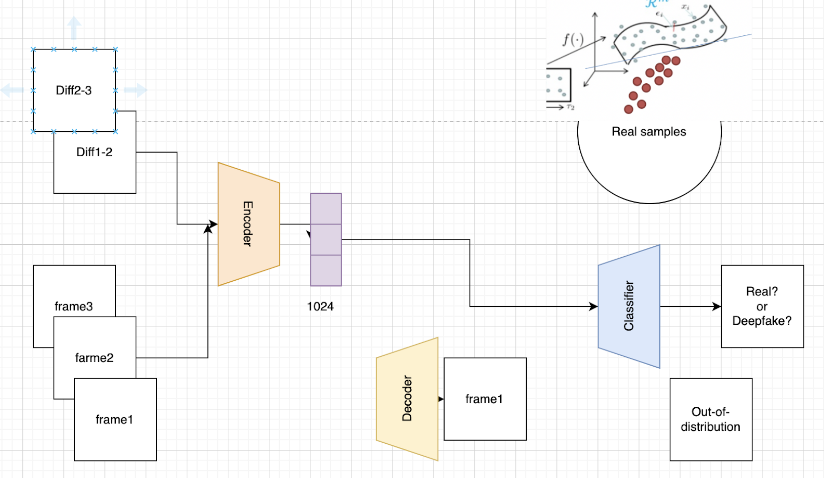

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np

torch.cuda.is_available()

True

In [ ]:
# classifier
class DeepFakeClassifier(nn.Module):
  def __init__(self, in_feature, out_feature):

    super(DeepFakeClassifier, self).__init__()

    self.in_feature = in_feature # number of input features
    self.out_feature = out_feature # number of output features (2)

    self.linear1 = nn.Linear(self.in_feature, 100)
    self.linear2 = nn.Linear(100, self.out_feature)

    self.relu = nn.ReLU() # activation function

  def forward(self, x): # x : input data
    x = self.linear1(x)
    x = self.relu(x)

    x = self.linear2(x)

    return x

In [ ]:
model = DeepFakeClassifier(1024, 2)
model = model.cuda()

dummy_input = torch.randn(1, 1024)
dummy_input = dummy_input.cuda()

pred = model(dummy_input)
print(pred)

idx2class = {
    0 : 'Real', 
    1 : 'Fake'
}

print( idx2class[ int(pred.argmax(dim=1)) ] )

tensor([[ 0.0440, -0.0884]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real


In [ ]:
class DeepFakeAutoEncoder(nn.Module):
  def __init__(self):

    super(DeepFakeAutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1), 
        nn.ReLU(), 
        nn.Conv2d(32, 64, kernel_size =3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(256, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(512, 512, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )

    self.decoder = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(32, 3, kernel_size=3, padding=1),
    )

  def forward(self, x):
    latent_variable = self.encoder(x)
    y = self.decoder(latent_variable)
    return y

In [ ]:
autoencoder = DeepFakeAutoEncoder()
autoencoder = autoencoder.cuda()

dummy_image = torch.randn(1, 3, 224, 224)
dummy_image = dummy_image.cuda()

reconstructed_image = autoencoder(dummy_image)

print(reconstructed_image.shape)

torch.Size([1, 3, 224, 224])


1. dataset load (image load)
2. numpy type -> torch.tensor type
3. image resize (224, 224)
4. data augumentation
5. ground truth load

In [ ]:
class DeepFakeDataset(Dataset):
  def __init__(self, image_dir, transform):
    super(DeepFakeDataset, self).__init__()

    self.image_dir = image_dir
    self.transform = transform

    self.samples = ['real1', 'real2', 'fake3', 'fake4']
    self.gt = [0, 0, 1, 1] # ground truth

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    # sample = self.samples[idx]
    # sample = torch.randn(3, 224, 224)

    sample = np.ones((3, 224, 224)).astype(np.float32)

    sample = self.transform(sample)

    gt = torch.LongTensor([self.gt[idx]]).squeeze()
    return sample, gt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

my_dataset = DeepFakeDataset('abc', transform)
len(my_dataset)

for x, y in my_dataset:
  print(x.shape, y)

torch.Size([224, 3, 224]) tensor(0)
torch.Size([224, 3, 224]) tensor(0)
torch.Size([224, 3, 224]) tensor(1)
torch.Size([224, 3, 224]) tensor(1)
